In [17]:
# attach to the same event-loop
import nest_asyncio

nest_asyncio.apply()

In [18]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, ServiceContext, Settings

import pandas as pd

In [22]:
import streamlit as st
from llama_index.core.postprocessor import MetadataReplacementPostProcessor
from llama_index.core.response_synthesizers import Refine, get_response_synthesizer
from llama_index.core.prompts import PromptTemplate
from llama_index.finetuning import EmbeddingAdapterFinetuneEngine
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.core.embeddings import resolve_embed_model
from llama_index.embeddings.adapter.utils import TwoLayerNN
from llama_index.llms.anthropic import Anthropic
from pinecone import Pinecone
from llama_index.vector_stores.pinecone import PineconeVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.postprocessor.cohere_rerank import CohereRerank

# 1. Enhanced Solution
In this solution, I am using GPT 3.5 to fine-tune embedding adapter on top of BAAI/bge-m3. The reason I'm using BAAI/bge-m3 as embedding is because it is multi-language, so it already exposed by Bahasa Indonesia on pre-training. To enhance its retrieval capability, I decided to fine-tune an adapter on top of embeddings produced by BAAI/bge-m3 using 2-layer Convolution Neural Network (CNN).

## 1.1 Initializing Index

In [20]:
llm = Anthropic(model="claude-3-sonnet-20240229", api_key=st.secrets.anthropic.api_key, max_tokens=4096, temperature=0)
dataset = EmbeddingQAFinetuneDataset.from_json("uu13_dataset.json")
base_embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-m3")
adapter_model = TwoLayerNN(
    1024,
    8194,
    1024,
    bias=True,
    add_residual=True,
)

finetune_engine = EmbeddingAdapterFinetuneEngine(
    dataset,
    base_embed_model,
    model_output_path="model5_output_test",
    model_checkpoint_path="model5_ck",
    adapter_model=adapter_model,
    epochs=5,
    verbose=True,
    dim=1024
)

embed_model = finetune_engine.get_finetuned_model(
    adapter_cls=TwoLayerNN
)
Settings.llm = llm
Settings.embed_model = embed_model

pc = Pinecone(api_key=st.secrets.pinecone.api_key)
pc_index = pc.Index("uu13")

vector_store = PineconeVectorStore(
    pinecone_index=pc_index
)
index = VectorStoreIndex.from_vector_store(vector_store=vector_store)

## 1.2 Custom Prompts
Also, in this solution I add a custom prompt to enhance the QA and answer refinement process. Notice that I'm adding `MetadataReplacementPostProcessor`on query engine's node processor, that is because upon building the dataset for the document I was using Sentence Window Retrieval technique. It's being used to enhance the AI capability to learn about the context, because it won't only retrieve the immediate matched index, but also the surrounding indexes, I prefer to include 8 indexes before and after the matched index.

In [23]:
qa_prompt_tmpl_str = (
    "Anda adalah ahli hukum ketenagakerjaan Indonesia, dan anda bagian dari kelas pekerja.\n"
    "Di bawah ini adalah konteks:"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Jawablah berdasarkan konteks. Jika tidak tahu, jangan mengarang atau improvisasi, jawab saja 'Maaf, belum bisa dijawab. Silahkan cek peraturan.go.id, hukumonline.com, atau gajimu.com'\n"
    "Perhatikan kriteria berikut untuk memberikan jawaban berdasarkan konteks di atas:\n"
    "1. Gunakan perspektif pekerja.\n"
    "2. Perhatikan pertanyaan dengan teliti, apabila dalam pertanyaan tidak ada kaitannya dengan kelalaian pekerja, jangan berasumsi bahwa dasar dari pertanyaan karena adanya kelalaian dari pekerja.\n"
    "3. Perhatikan dengan teliti bahwa istilah/terminologi berikut memiliki makna yang berbeda: upah, upah minimum, upah kerja lembur, uang pesangon, uang penghargaan masa kerja, dan uang penggantian hak.\n"
    "4. Perhatikan dengan teliti setiap istilah/terminologi, jangan sampai tertukar!\n"
    "5. Perhatikan dengan teliti, apabila terdapat pernyataan matematis seperti: lebih dari, kurang dari, lebih tetapi kurang dari, atau sejenisnya.\n"
    "6. Tidak perlu menambahkan jawaban yang tidak sesuai dengan pertanyaan. Contoh, apabila ditanya mengenai pesangon, tidak perlu menambahkan jawaban mengenai upah penggantian hak.\n"
    "7. Jangan mengawali jawaban dengan, 'Berdasarkan konteks yang diberikan' atau sejenisnya.\n"
    "Perhatikan dan pertimbangkan seluruh kriteria dengan baik, karena akan diujikan nanti.\n"
    "Apabila anda dapat memenuhi kriteria-kriteria tersebut dan menghasilkan jawaban dengan baik, maka anda akan memperoleh hadiah milyaran rupiah.\n"
    "Jawablah pertanyaan di bawah dengan teliti, karena anda akan memperoleh hadiah jutaan rupiah apabila menjawab dengan tepat.\n"
    "Pertanyaan: {query_str}\n"
    "Jawaban: "
)
qa_prompt_tmpl = PromptTemplate(qa_prompt_tmpl_str)

refine_prompt_tmpl_str = (
    "Pertanyaan asli sebagai berikut: {query_str}\n"
    "Jawaban yang ditemukan sebagai berikut: {existing_answer}\n"
    "Anda memiliki kesempatan untuk memperbaiki jawaban.\n"
    "Apabila dibutuhkan, perbaikilah berdasarkan konteks di bawah.\n"
    "---------------------\n"
    "{context_msg}\n"
    "---------------------\n"
    "Dengan konteks baru tersebut, ubahlah jawaban awal agar lebih sesuai untuk menjawaban pertanyaan.\n"
    "Perhatikan kriteria berikut untuk melakukan perbaikan berdasarkan konteks di atas:\n"
    "1. Gunakan perspektif pekerja.\n"
    "2. Perhatikan pertanyaan dengan teliti, apabila dalam pertanyaan tidak ada kaitannya dengan kelalaian pekerja, jangan berasumsi bahwa dasar dari pertanyaan karena adanya kelalaian dari pekerja.\n"
    "3. Perhatikan dengan teliti bahwa istilah/terminologi berikut memiliki makna yang berbeda: upah, upah minimum, upah kerja lembur, uang pesangon, uang penghargaan masa kerja, dan uang penggantian hak.\n"
    "4. Perhatikan dengan teliti setiap istilah/terminologi, jangan sampai tertukar!\n"
    "5. Perhatikan dengan teliti, apabila terdapat pernyataan matematis seperti: lebih dari, kurang dari, lebih tetapi kurang dari, atau sejenisnya.\n"
    "6. Tidak perlu menambahkan jawaban yang tidak sesuai dengan pertanyaan. Contoh, apabila ditanya mengenai pesangon, tidak perlu menambahkan jawaban mengenai upah penggantian hak.\n"
    "7. Tidak perlu menyisipkan alasan dari perbaikan jawaban, cukup tampilkan jawaban terakhir.\n"
    "Perhatikan dan pertimbangkan seluruh kriteria dengan baik, karena akan diujikan nanti.\n"
    "Apabila anda dapat memenuhi kriteria-kriteria tersebut dan menghasilkan jawaban baru yang lebih baik, maka anda akan memperoleh hadiah milyaran rupiah.\n"
    "Jawaban Baru: "
)
refine_prompt_tmpl = PromptTemplate(refine_prompt_tmpl_str)

cohere_rerank = CohereRerank(api_key=st.secrets.cohere.api_key, top_n=3)
response_synthesizer = get_response_synthesizer(response_mode="refine")
query_engine = index.as_query_engine(
    similarity_top_k=8,
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window"),
        cohere_rerank
    ],
    response_synthesizer=response_synthesizer,
)
query_engine.update_prompts({
    "response_synthesizer:text_qa_template": qa_prompt_tmpl,
    "response_synthesizer:refine_template": refine_prompt_tmpl
})

## 1.3 Generate RAGAS Dataset

In [24]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall
)
from datasets import Dataset
from tqdm.auto import tqdm
import pandas as pd

metrics = [
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall
]

In [26]:
questions = [
              "Apakah pekerja berhak mendapatkan pelatihan?", 
              "Dalam pekerjaan dengan waktu tertentu, apabila pemberi kerja memutuskan hubungan kerja sebelum habisnya jangka waktu yang ditetapkan, apa kewajiban yang harus dipenuhi?",
              "Saya membutuhkan pekerja muda berusia 14 tahun untuk mengurus anak saya, kemungkinan akan dipekerjakan selama 12 jam per hari, dengan upah di atas upah minimum. Apakah yang saya lakukan melanggar peraturan?",
              "Sanksi atau denda apa yang dapat dikenakan pada pengusaha apabila memberikan perintah kepada saya untuk bekerja di jam 12 malam hingga 5 pagi, sedangkan saya sedang hamil?",
              "Dalam 1 minggu ini, saya telah melakukan kerja lembur setiap hari, jika ditotal saya telah lembur sebanyak 21 jam pada minggu ini. Pengusaha membayar saya dengan pizza, apakah itu diperbolehkan?",
              "Sanksi apa yang dapat dikenakan pada pengusaha yang mempekerjakan pekerjaanya pada hari libur resmi tanpa membayar upah kerja lembur?",
              "Apabila pekerja tidak bekerja karena menikahkan anaknya, apakah tetap berhak mendapatkan upah?",
              "Apabila perusahaan pailit, apakah saya tetap berhak mendapatkan upah dan hak-hak jaminan sosial lainnya?",
              "Dalam hubungan industrial, apa fungsi dari pengusaha?",
              "Apakah serikat pekerja merupakan unsur yang termasuk dalam lembaga kerja sama bipartit?",
              "Sanksi apa yang akan dikenakan pada pengusaha yang mengganti pekerja mogok dengan pekerja dari luar?",
              "Apabila saya diberhentikan setelah bekerja selama 3 tahun 9 bulan, berapa uang pesangon yang berhak saya dapatkan?"
            ]
ground_truths = [
                  "Setiap tenaga kerja berhak untuk mengembangkan kompetensi kerja sesuai dengan bakat, minat, dan kemampuannya melalui pelatihan kerja. Pengusaha juga memiliki tanggung jawab atas pengembangan kompetensi tenaga kerjanya.",
                  "Apabila pemutusan hubungan kerja dilakukan selain karena pekerja meninggal dunia, maka pemberi kerja wajib membayar ganti rugi sebesar upah pekerja/buruh sampai batas waktu berakhirnya jangka waktu perjanjian kerja.",
                  "Meski anda memberi upah di atas upah minimum, mempekerjakan anak-anak merupakan hal yang dilarang. Ada pengecualian apabila pekerja muda tersebut berusia di antara 13 sampai dengan 15 tahun, untuk dipekerjakan secara ringan tanpa mengganggu perkembangan dan kesehatan fisik, mental, dan sosial. Mempekerjakan 12 jam per hari merupakan pelanggaran, karena hanya diperbolehkan untuk bekerja maksimum 3 jam.",
                  "Pengusaha dilarang untuk memperkjakan perempuan yang sedang hamil antara pukul 23:00 sampai dengan pukul 07:00. Apabila dilanggar, sesuai dengan Pasal 187 ayat 1 pada Undang-undang Nomor 13 Tahun 2003 maka pengusaha dapat dikenakan sanksi pidana kurungan paling singkat 1 (satu) bulan dan paling lama 12 (dua belas) bulan dan/atau denda paling sedikit Rp 10.000.000,00 (sepuluh juta rupiah) dan paling banyak Rp 100.000.000,00 (seratus juta rupiah).",
                  "Apabila hanya diberi pizza, tanpa upah lembur, maka itu telah melanggar peraturan. sesuai dengan Pasal 187 ayat 1 pada Undang-undang Nomor 13 Tahun 2003 pengusaha dapat dikenakan sanksi pidana kurungan paling singkat 1 (satu) bulan dan paling lama 12 (dua belas) bulan dan/atau denda paling sedikit Rp 10.000.000,00 (sepuluh juta rupiah) dan paling banyak Rp 100.000.000,00 (seratus juta rupiah).",
                  "Sesuai dengan Pasal 187 ayat 1 pada Undang-undang Nomor 13 Tahun 2003, pengusaha dapat dikenakan sanksi pidana kurungan paling singkat 1 (satu) bulan dan paling lama 12 (dua belas) bulan dan/atau denda paling sedikit Rp 10.000.000,00 (sepuluh juta rupiah) dan paling banyak Rp 100.000.000,00 (seratus juta rupiah).",
                  "Pekerja yang tidak bekerja disebabkan sedang menikahkan anaknya berhak diupah sesuai pasal 93 ayat 2. Besarannya 2 hari upah, sesuai yang diatur pada pasal 93 ayat 4.",
                  "Bagi perusahaan yang pailit upah dan hak-hak lainnya yang dimiliki pekerja/buruh akan menjadi utang yang didahulukan pembayarannya oleh pengusaha.",
                  "Pengusaha mempunyai fungsi menciptakan kemitraan, mengembangkan usaha, memperluas lapangan kerja, dan memberikan kesejahteraan pekerja secara terbuka, demokratis, dan berkeadilan.",
                  "Tidak. Unsur serikat pekerja ada di dalam lembaga kerja sama tripartit, bersama dengan unsur pemerintah dan organisasi pengusaha, sesuai dengan pasal 107 ayat 3. Pada lembaga kerja sama bipartit terdiri dari unsur pengusaha dan unsur pekerja/buruh yang ditunjuk oleh pekerja/buruh secara demokratis untuk mewakili kepentingan pekerja/buruh di perusahaan yang bersangkutan, sesuai dengan pasal 106 ayat 3.",
                  "Berdasarkan pasal 144 ayat 1, pengusaha dilarang mengganti pekerja mogok denga pekerja dari luar perusahaan. Sesuai dengan Pasal 187 ayat 1 pada Undang-undang Nomor 13 Tahun 2003, pengusaha dapat dikenakan sanksi pidana kurungan paling singkat 1 (satu) bulan dan paling lama 12 (dua belas) bulan dan/atau denda paling sedikit Rp 10.000.000,00 (sepuluh juta rupiah) dan paling banyak Rp 100.000.000,00 (seratus juta rupiah).",
                  "Berdasarkan pasal 156 ayat 2, pekerja yang telah diberhentikan setelah bekerja selama 3 tahun atau lebih tetapi kurang dari 4 tahun, berhak mendapatkan uang pesangon sebesar 4 bulan upah."
                ]

In [27]:
def generate_response(query_engine, question):
    summarizer = Refine(refine_template=refine_prompt_tmpl, structured_answer_filtering=True)
    
    response = query_engine.query(question)
    windows = [node.metadata["window"] for node in response.source_nodes]
    summarized_res = summarizer.get_response(question, windows)
    return {
        "answer": summarized_res,
        "contexts": windows,
    }


def generate_ragas_dataset(query_engine, questions, ground_truths):
    responses = [generate_response(query_engine, q) for q in tqdm(questions)]
    
    dataset_dict = {
        "question": questions,
        "answer": [response["answer"] for response in responses],
        "contexts": [response["contexts"] for response in responses],
        "ground_truth": ground_truths,
    }
    ds = Dataset.from_dict(dataset_dict)
    return ds


ragas_eval_dataset = generate_ragas_dataset(query_engine, questions, ground_truths)
ragas_evals_df = pd.DataFrame(ragas_eval_dataset)
ragas_evals_df.head()

  0%|          | 0/12 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/eryz/Documents/projects/TA/pekerja-gpt/.venv/lib/python3.10/site-packages/llama_index/core/program/utils.py:58: UserWarning: Failed to use `OpenAIPydanticProgram`. Please ensure that is installed by running `pip install llama-index-program-openai`.
  warnings.warn(


,question,answer,contexts,ground_truth
0,Apakah pekerja berhak mendapatkan pelatihan?,"Ya, setiap pekerja berhak untuk memperoleh dan...",[(1) Tenaga kerja berhak memperoleh pengakuan ...,Setiap tenaga kerja berhak untuk mengembangkan...
1,"Dalam pekerjaan dengan waktu tertentu, apabila...",Jika pemberi kerja memutuskan hubungan kerja s...,[C. Perjanjian Kerja untuk Suatu Jangka Waktu ...,Apabila pemutusan hubungan kerja dilakukan sel...
2,Saya membutuhkan pekerja muda berusia 14 tahun...,"Tidak, mempekerjakan anak berusia 14 tahun sel...",[e. memberlakukan keselamatan dan kesehatan ke...,"Meski anda memberi upah di atas upah minimum, ..."
3,Sanksi atau denda apa yang dapat dikenakan pad...,"Berdasarkan Pasal 187 ayat (1), pengusaha yang...",[memberikan kesempatan kepada para pekerja unt...,Pengusaha dilarang untuk memperkjakan perempua...
4,"Dalam 1 minggu ini, saya telah melakukan kerja...","Tidak, pembayaran upah dengan pizza saja tidak...",[e. memberlakukan keselamatan dan kesehatan ke...,"Apabila hanya diberi pizza, tanpa upah lembur,..."


In [28]:
ragas_evals_df.to_csv("enhanced_solution.csv")

## 1.4 Evaluation Result

In [31]:
from ragas import evaluate
import os
os.environ["OPENAI_API_KEY"] = st.secrets.openai.api_key
evaluation_result = evaluate(
    dataset=ragas_eval_dataset,
    metrics=metrics,
)
eval_scores_df = pd.DataFrame(evaluation_result.scores)

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [43]:
eval_scores_df.head(12)

,faithfulness,answer_relevancy,context_precision,context_recall
0,1.000000,0.899568,1.0000,1.000000
1,1.000000,0.849207,1.0000,1.000000
2,1.000000,0.920993,1.0000,0.666667
3,1.000000,0.789451,1.0000,1.000000
4,0.666667,0.880675,1.0000,1.000000
5,1.000000,0.977997,1.0000,1.000000
6,0.500000,0.957566,1.0000,1.000000
7,1.000000,0.861411,0.8875,1.000000
8,0.600000,0.975788,1.0000,1.000000
9,1.000000,0.925613,1.0000,0.500000


In [32]:
print(evaluation_result)

{'faithfulness': 0.9139, 'answer_relevancy': 0.8975, 'context_precision': 1.0000, 'context_recall': 0.9306}


# 2. Base Solution
In this solution, I am using GPT 3.5 and Ada as embedding model. I won't create a custom prompts and the retrieval process would using text splitter rather than an advanced technique such as sentence window retrieval. I expect the evaluation result would be less better than the previous solution.

## 2.1 Initializing Index

In [33]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
import os
files = ["./uu_no_13_th_2003.pdf", "./uu_13_explained.pdf"]
os.environ["OPENAI_API_KEY"] = st.secrets.openai.api_key

documents = SimpleDirectoryReader(
    input_files=files
).load_data()

text_splitter = SentenceSplitter()

llm = OpenAI(model="gpt-3.5-turbo", temperature=0)
embed_model = OpenAIEmbedding(model="text-embedding-ada-002")

Settings.llm = llm
Settings.embed_model = embed_model

nodes = text_splitter.get_nodes_from_documents(documents)
index = VectorStoreIndex(nodes)

query_engine = index.as_query_engine(similarity_top_k=2)

## 2.2 Generate RAGAS Dataset

In [34]:
def generate_base_response(query_engine, question):
    response = query_engine.query(question)
    return {
        "answer": response.response,
        "contexts": [c.node.get_content() for c in response.source_nodes],
    }


def generate_base_ragas_dataset(query_engine, questions, ground_truths):
    responses = [generate_base_response(query_engine, q) for q in tqdm(questions)]

    dataset_dict = {
        "question": questions,
        "answer": [response["answer"] for response in responses],
        "contexts": [response["contexts"] for response in responses],
        "ground_truth": ground_truths,
    }
    ds = Dataset.from_dict(dataset_dict)
    return ds


base_ragas_eval_dataset = generate_base_ragas_dataset(query_engine, questions, ground_truths)
base_ragas_evals_df = pd.DataFrame(base_ragas_eval_dataset)
base_ragas_evals_df.head()

  0%|          | 0/12 [00:00<?, ?it/s]

,question,answer,contexts,ground_truth
0,Apakah pekerja berhak mendapatkan pelatihan?,Setiap tenaga kerja berhak untuk memperoleh da...,[(1) Tenaga kerja berhak memperoleh pengakuan ...,Setiap tenaga kerja berhak untuk mengembangkan...
1,"Dalam pekerjaan dengan waktu tertentu, apabila...",Pihak yang mengakhiri hubungan kerja sebelum b...,[(5) Pengusaha yang bermaksud memperpanjang pe...,Apabila pemutusan hubungan kerja dilakukan sel...
2,Saya membutuhkan pekerja muda berusia 14 tahun...,Melanggar peraturan karena anak yang berusia 1...,[e. memberlakukan keselamatan dan kesehatan ke...,"Meski anda memberi upah di atas upah minimum, ..."
3,Sanksi atau denda apa yang dapat dikenakan pad...,Sanksi atau denda yang dapat dikenakan pada pe...,[Pekerja perempuan berhak memperoleh istirahat...,Pengusaha dilarang untuk memperkjakan perempua...
4,"Dalam 1 minggu ini, saya telah melakukan kerja...",Pengusaha harus membayar upah kerja lembur kep...,[(4) Ketentuan mengenai waktu kerja pada sekto...,"Apabila hanya diberi pizza, tanpa upah lembur,..."


In [35]:
base_ragas_evals_df.head(12)
base_ragas_evals_df.to_csv("base_solution.csv")

## 2.3 Evaluation Result

In [36]:
base_evaluation_result = evaluate(
    dataset=base_ragas_eval_dataset,
    metrics=metrics,
)
base_eval_scores_df = pd.DataFrame(base_evaluation_result.scores)

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

In [37]:
base_eval_scores_df.head(12)

,faithfulness,answer_relevancy,context_precision,context_recall
0,1.00,0.910125,1.0,1.0
1,1.00,0.914240,1.0,1.0
2,1.00,0.867084,1.0,1.0
3,1.00,0.967009,1.0,1.0
4,0.25,0.870958,1.0,0.5
5,1.00,0.970747,1.0,1.0
6,1.00,0.966083,1.0,1.0
7,0.00,0.819824,1.0,1.0
8,1.00,0.976960,1.0,1.0
9,1.00,0.870339,1.0,1.0


In [38]:
print(base_evaluation_result)

{'faithfulness': 0.8125, 'answer_relevancy': 0.9169, 'context_precision': 0.9583, 'context_recall': 0.9167}


[Text(0, 0, '0.913889'),
 Text(0, 0, '0.897504'),
 Text(0, 0, '1'),
 Text(0, 0, '0.930556')]

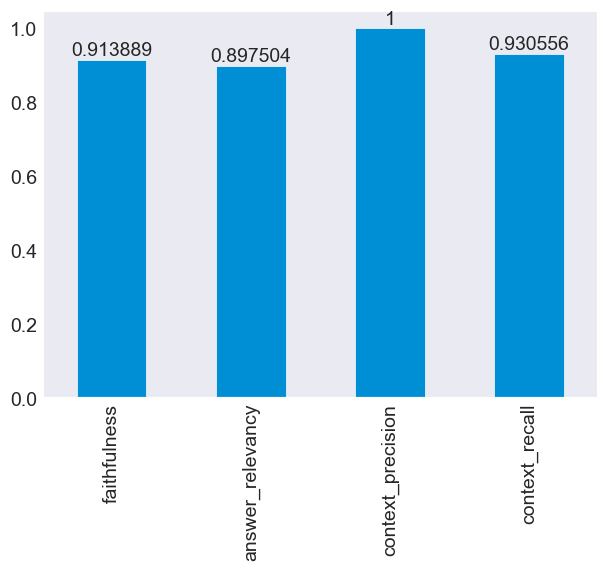

In [46]:
plotPekerjaGPT = pd.DataFrame({
  "scores": list(evaluation_result.values()),
}, index=['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall'])
pkg = plotPekerjaGPT['scores'].plot(kind='bar')
pkg.bar_label(pkg.containers[0])

[Text(0, 0, '0.8125'),
 Text(0, 0, '0.916902'),
 Text(0, 0, '0.958333'),
 Text(0, 0, '0.916667')]

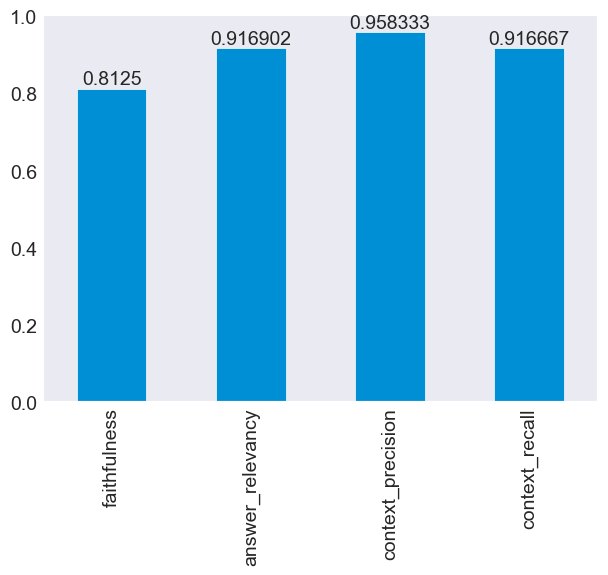

In [45]:
plotBase = pd.DataFrame({
  "scores": list(base_evaluation_result.values()),
}, index=['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall'])
pb = plotBase['scores'].plot(kind='bar')
pb.bar_label(pb.containers[0])

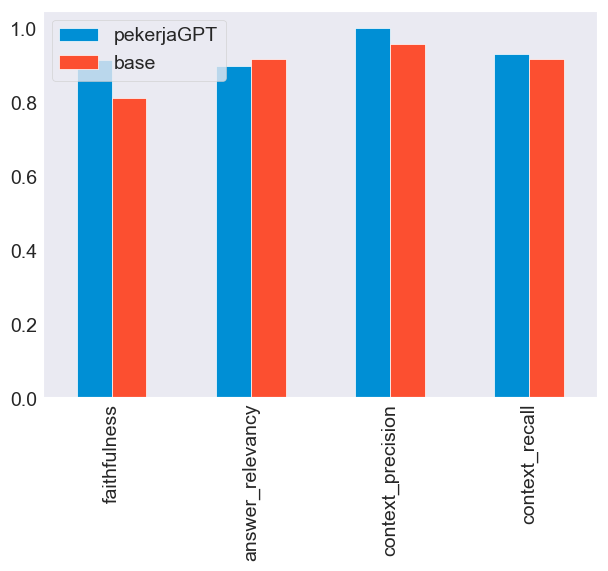

In [48]:
plotData = pd.DataFrame({
  "pekerjaGPT": list(evaluation_result.values()),
  "base": list(base_evaluation_result.values())
}, index=['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall'])
pld = plotData[["pekerjaGPT", "base"]].plot(kind='bar')